In [5]:
import os
import matplotlib.pyplot as plt
import torch
from eval import *
from preprocessing import *
from lstm import load_fasttext

ROOT_DIR = os.path.dirname(os.path.abspath(""))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# split data into training and validation
val_frac = 0.2
with open(os.path.join(ROOT_DIR, "data", "training_data.json"), "r", encoding="utf8") as _f:
	train_data = json.load(_f)

val_docs = int(val_frac * len(train_data))
val_data = train_data[:val_docs]
with open(os.path.join(ROOT_DIR, "data", "val_set_data.json"), "w", encoding="utf8") as _f:
	json.dump(val_data, _f)
new_train_data = train_data[val_docs:]
with open(os.path.join(ROOT_DIR, "data", "train_set_data.json"), "w", encoding="utf8") as _f:
	json.dump(new_train_data, _f)

In [3]:
ft = load_fasttext()

In [8]:
eval = EvalLSTM(
	save_dir=os.path.join(ROOT_DIR, "temp"),
	results_dir=os.path.join(ROOT_DIR, "data"),
	train_data_path=os.path.join(ROOT_DIR, "data", "train_set_data.json"),
	eval_data_path=os.path.join(ROOT_DIR, "data", "val_set_data.json"),
	fasttext_model=ft,
	lemmatize=False,
	remove_punctuation=True,
	replace_numbers=None,
	verbose=True
)

Creating evaluation tokens...


100%|██████████| 50/50 [00:00<00:00, 67.04it/s]


Creating training tokens...


100%|██████████| 204/204 [00:02<00:00, 72.90it/s]


Precomputing training POS tags...


100%|██████████| 204/204 [00:49<00:00,  4.11it/s]


Precomputing evaluation POS tags...


100%|██████████| 50/50 [00:12<00:00,  3.97it/s]


Loading NLP models...
Precomputing training lemmas...


100%|██████████| 204/204 [00:54<00:00,  3.72it/s]


Precomputing evaluation lemmas...


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


cuda
Instantiating LSTM...
Training LSTM...
Preparing training set...
Training model...
Epoch [1/1], Batch [4600/4600], Loss: 0.0154760777950286876
Predicting...


100%|██████████| 1105/1105 [00:08<00:00, 131.37it/s]


Calculating metrics...
{'precision': 0.9602037195348162, 'recall': 0.9602037195348162, 'f1': 0.9602037195348162, 'time': 8.9967}


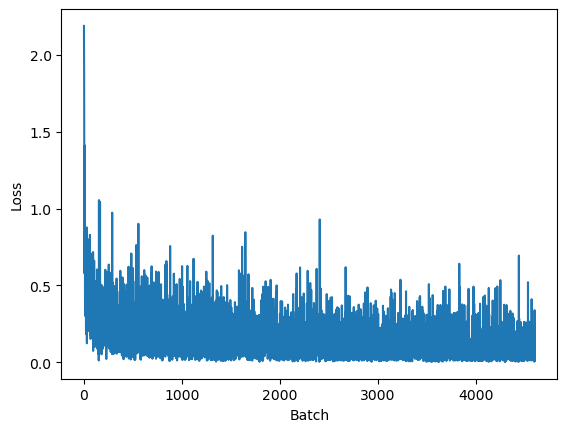

In [13]:
hyperparams = {
	"input_dim": 617,
	"hidden_dim": 300,
	"num_layers": 2,
	"output_dim": 9,
	"seq_len": 10,
	"epochs": 1,
	"batch_size": 32,
	"learning_rate": 1e-3,
	"num_workers": 12
}
metrics, losses = eval.evaluate(**hyperparams)
print(metrics)
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss");

In [14]:
eval.model.save()

### Hyperparameter analysis

In [8]:
eval = EvalLSTM(
	save_dir=os.path.join(ROOT_DIR, "temp"),
	results_dir=os.path.join(ROOT_DIR, "data"),
	train_data_path=os.path.join(ROOT_DIR, "data", 'train_set_data.json'),
	eval_data_path=os.path.join(ROOT_DIR, "data", 'val_set_data.json'),
	device=device,
	fasttext_model=ft,
	load_existing_train_tokens=True,
	load_existing_eval_tokens=True,
	load_existing_train_pos=True,
	load_existing_eval_pos=True,
	load_existing_train_lemmas=True,
	load_existing_eval_lemmas=True,
	lemmatize=False,
	remove_punctuation=True,
	replace_numbers=None,
	verbose=False
)

In [9]:
combinations = eval.random_search(
	{
		"input_dim": [617],
		"hidden_dim": range(64, 512+64, 64),
		"num_layers": range(1, 4),
		"output_dim": [9],
		"seq_len": range(5, 21, 5),
		"epochs": [1],
		"batch_size": [32],
		"learning_rate": [1e-3],
		"num_workers": [12]		
	},
	n_iter=10
)

In [13]:
combinations[0]

{'metrics': {'precision': 0.9631353129990161,
  'recall': 0.9631353129990161,
  'f1': 0.9631353129990161,
  'time': 14.466},
 'hyperparameters': {'input_dim': 617,
  'hidden_dim': 448,
  'num_layers': 2,
  'output_dim': 9,
  'seq_len': 15,
  'epochs': 1,
  'batch_size': 32,
  'learning_rate': 0.001,
  'num_workers': 12,
  'lemmatize': False,
  'remove_punctuation': True,
  'replace_numbers': None}}

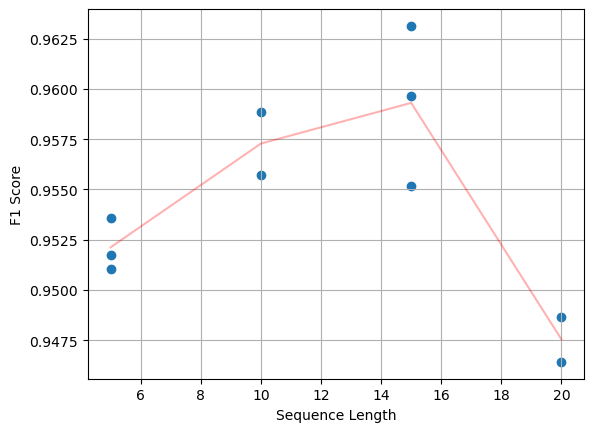

In [20]:
seq_len = [combo["hyperparameters"]["seq_len"] for combo in combinations]
f1 = [combo["metrics"]["f1"] for combo in combinations]
# compute f1 average for each seq_len value
seq_len2f1 = {seq: [] for seq in seq_len}
for i, seq in enumerate(seq_len):
	seq_len2f1[seq].append(f1[i])
f1_avg = [sum(seq_len2f1[seq]) / len(seq_len2f1[seq]) for seq in seq_len2f1]
seq_len2 = list(seq_len2f1.keys())
# sort
seq_len2, f1_avg = zip(*sorted(zip(seq_len2, f1_avg)))
plt.scatter(seq_len, f1)
plt.plot(seq_len2, f1_avg, color="red", alpha=0.3)
plt.xlabel("Sequence Length")
plt.ylabel("F1 Score")
plt.grid(True);

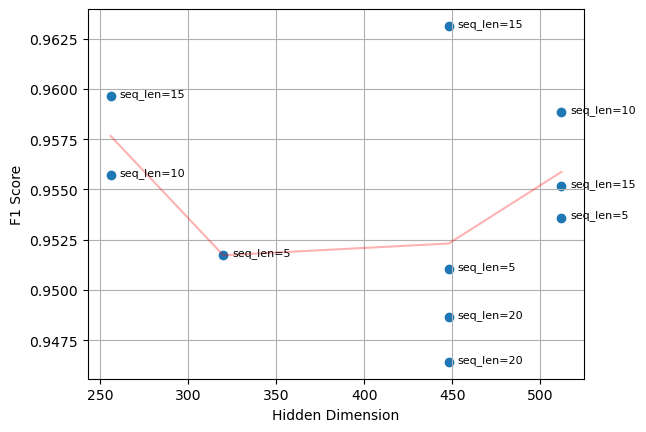

In [8]:
# same with hidden_dim
hidden_dim = [combo["hyperparameters"]["hidden_dim"] for combo in combinations]
f1 = [combo["metrics"]["f1"] for combo in combinations]
hidden_dim2f1 = {hd: [] for hd in hidden_dim}
for i, hd in enumerate(hidden_dim):
	hidden_dim2f1[hd].append(f1[i])
f1_avg = [sum(hidden_dim2f1[hd]) / len(hidden_dim2f1[hd]) for hd in hidden_dim2f1]
hidden_dim2 = list(hidden_dim2f1.keys())
hidden_dim2, f1_avg = zip(*sorted(zip(hidden_dim2, f1_avg)))
seq_len = [combo["hyperparameters"]["seq_len"] for combo in combinations]
plt.scatter(hidden_dim, f1)
plt.plot(hidden_dim2, f1_avg, color="red", alpha=0.3)
for i in range(len(hidden_dim)):
    plt.text(hidden_dim[i]+5, f1[i], f'seq_len={seq_len[i]}', fontsize=8)
plt.xlabel("Hidden Dimension")
plt.ylabel("F1 Score")
plt.grid(True);

### Ablation studies

In [1]:
import os
import matplotlib.pyplot as plt
import torch
from eval import *
from preprocessing import *
from lstm import load_fasttext

ROOT_DIR = os.path.dirname(os.path.abspath(""))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
ft = load_fasttext()

Here we change input sequence split from 5-5 to 6-4 (the change is made somewhere else, not shown here)

In [18]:
eval = EvalLSTM(
	save_dir=os.path.join(ROOT_DIR, "temp"),
	results_dir=os.path.join(ROOT_DIR, "data"),
	train_data_path=os.path.join(ROOT_DIR, "data", 'train_set_data.json'),
	eval_data_path=os.path.join(ROOT_DIR, "data", 'val_set_data.json'),
	device=device,
	fasttext_model=ft,
	lemmatize=False,
	remove_punctuation=True,
	replace_numbers=None,
	verbose=True
)

Creating evaluation tokens...


100%|██████████| 50/50 [00:00<00:00, 54.90it/s]


Creating training tokens...


100%|██████████| 204/204 [00:02<00:00, 70.71it/s]


Precomputing training POS tags...


100%|██████████| 204/204 [00:48<00:00,  4.21it/s]


Precomputing evaluation POS tags...


100%|██████████| 50/50 [00:12<00:00,  3.97it/s]


Loading NLP models...
Precomputing training lemmas...


100%|██████████| 204/204 [00:48<00:00,  4.22it/s]


Precomputing evaluation lemmas...


100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


In [20]:
# taking previous best hyperparameters
hyperparams = {
		"input_dim": 617,
		"hidden_dim": 448,
		"num_layers": 2,
		"output_dim": 9,
		"seq_len": 15,
		"epochs": 1,
		"batch_size": 32,
		"learning_rate": 1e-3,
		"num_workers": 12
	}
metrics, losses = eval.evaluate(**hyperparams)

Instantiating LSTM...
Training LSTM...
Preparing training set...
Training model...
Epoch [1/1], Batch [4600/4600], Loss: 0.1459958255290985964
Predicting...


100%|██████████| 1105/1105 [00:13<00:00, 83.78it/s]


Calculating metrics...


In [21]:
metrics

{'precision': 0.9535663015952385,
 'recall': 0.9535663015952385,
 'f1': 0.9535663015952385,
 'time': 13.4578}

In [4]:
# Here we change input sequence split from 5-5 to 8-2
# (the change is made somewhere else, not shown here)
eval = EvalLSTM(
	save_dir=os.path.join(ROOT_DIR, "temp"),
	results_dir=os.path.join(ROOT_DIR, "data"),
	train_data_path=os.path.join(ROOT_DIR, "data", 'train_set_data.json'),
	eval_data_path=os.path.join(ROOT_DIR, "data", 'val_set_data.json'),
	device=device,
	fasttext_model=ft,
	load_existing_train_tokens=True,
	load_existing_eval_tokens=True,
	load_existing_train_pos=True,
	load_existing_eval_pos=True,
	load_existing_train_lemmas=True,
	load_existing_eval_lemmas=True,
	lemmatize=False,
	remove_punctuation=True,
	replace_numbers=None,
	verbose=True
)
hyperparams = {
		"input_dim": 617,
		"hidden_dim": 448,
		"num_layers": 2,
		"output_dim": 9,
		"seq_len": 15,
		"epochs": 1,
		"batch_size": 32,
		"learning_rate": 1e-3,
		"num_workers": 12
	}
metrics, losses = eval.evaluate(**hyperparams)
metrics

Loading NLP models...
Instantiating LSTM...
Training LSTM...
Preparing training set...
Training model...
Epoch [1/1], Batch [4600/4600], Loss: 0.2864117920398712125
Predicting...


100%|██████████| 1105/1105 [00:13<00:00, 81.13it/s]


Calculating metrics...


{'precision': 0.960937626014162,
 'recall': 0.960937626014162,
 'f1': 0.960937626014162,
 'time': 13.8608}

In [5]:
# Here we try to keep punctuation
eval = EvalLSTM(
	save_dir=os.path.join(ROOT_DIR, "temp"),
	results_dir=os.path.join(ROOT_DIR, "data"),
	train_data_path=os.path.join(ROOT_DIR, "data", 'train_set_data.json'),
	eval_data_path=os.path.join(ROOT_DIR, "data", 'val_set_data.json'),
	device=device,
	fasttext_model=ft,
	lemmatize=False,
	remove_punctuation=False,
	replace_numbers=None,
	verbose=True
)
hyperparams = {
		"input_dim": 617,
		"hidden_dim": 448,
		"num_layers": 2,
		"output_dim": 9,
		"seq_len": 15,
		"epochs": 1,
		"batch_size": 32,
		"learning_rate": 1e-3,
		"num_workers": 12
	}
metrics, losses = eval.evaluate(**hyperparams)
metrics

Creating evaluation tokens...


100%|██████████| 50/50 [00:00<00:00, 66.63it/s]


Creating training tokens...


100%|██████████| 204/204 [00:03<00:00, 52.79it/s]


Precomputing training POS tags...


100%|██████████| 204/204 [01:39<00:00,  2.06it/s]


Precomputing evaluation POS tags...


100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


Loading NLP models...
Precomputing training lemmas...


100%|██████████| 204/204 [01:39<00:00,  2.05it/s]


Precomputing evaluation lemmas...


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


Instantiating LSTM...
Training LSTM...
Preparing training set...
Training model...
Epoch [1/1], Batch [5671/5671], Loss: 0.0077759074047207833
Predicting...


100%|██████████| 1353/1353 [00:25<00:00, 52.61it/s]


Calculating metrics...


{'precision': 0.9706518057325354,
 'recall': 0.9706518057325354,
 'f1': 0.9706518057325354,
 'time': 26.4395}

In [6]:
# Here we try to keep replace numbers with constant token
eval = EvalLSTM(
	save_dir=os.path.join(ROOT_DIR, "temp"),
	results_dir=os.path.join(ROOT_DIR, "data"),
	train_data_path=os.path.join(ROOT_DIR, "data", 'train_set_data.json'),
	eval_data_path=os.path.join(ROOT_DIR, "data", 'val_set_data.json'),
	device=device,
	fasttext_model=ft,
	lemmatize=False,
	remove_punctuation=False,
	replace_numbers="<NUM>",
	verbose=True
)
hyperparams = {
		"input_dim": 617,
		"hidden_dim": 448,
		"num_layers": 2,
		"output_dim": 9,
		"seq_len": 15,
		"epochs": 1,
		"batch_size": 32,
		"learning_rate": 1e-3,
		"num_workers": 12
	}
metrics, losses = eval.evaluate(**hyperparams)
metrics

Creating evaluation tokens...


100%|██████████| 50/50 [00:01<00:00, 32.28it/s]


Creating training tokens...


100%|██████████| 204/204 [00:04<00:00, 47.92it/s]


Precomputing training POS tags...


100%|██████████| 204/204 [01:35<00:00,  2.13it/s]


Precomputing evaluation POS tags...


100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


Loading NLP models...
Precomputing training lemmas...


100%|██████████| 204/204 [01:28<00:00,  2.31it/s]


Precomputing evaluation lemmas...


100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


Instantiating LSTM...
Training LSTM...
Preparing training set...
Training model...
Epoch [1/1], Batch [5671/5671], Loss: 0.0695391818881034925
Predicting...


100%|██████████| 1353/1353 [00:20<00:00, 64.51it/s]


Calculating metrics...


{'precision': 0.9732406406761618,
 'recall': 0.9732406406761618,
 'f1': 0.9732406406761618,
 'time': 21.6079}

In [7]:
eval.model.save()

In [3]:
# Here we try to add a dense layer before the lstm
eval = EvalLSTM(
	save_dir=os.path.join(ROOT_DIR, "temp"),
	results_dir=os.path.join(ROOT_DIR, "data"),
	train_data_path=os.path.join(ROOT_DIR, "data", 'train_set_data.json'),
	eval_data_path=os.path.join(ROOT_DIR, "data", 'val_set_data.json'),
	device=device,
	fasttext_model=ft,
	load_existing_train_tokens=True,
	load_existing_eval_tokens=True,
	load_existing_train_pos=True,
	load_existing_eval_pos=True,
	load_existing_train_lemmas=True,
	load_existing_eval_lemmas=True,
	lemmatize=False,
	remove_punctuation=False,
	replace_numbers="<NUM>",
	verbose=True
)
hyperparams = {
		"input_dim": 617,
		"hidden_dim": 448,
		"num_layers": 2,
		"output_dim": 9,
		"seq_len": 15,
		"epochs": 1,
		"batch_size": 32,
		"learning_rate": 1e-3,
		"num_workers": 12
	}
metrics, losses = eval.evaluate(**hyperparams)
metrics

Loading NLP models...
Instantiating LSTM...
Training LSTM...
Preparing training set...
Training model...
Epoch [1/1], Batch [5671/5671], Loss: 0.0583712495863437655
Predicting...


100%|██████████| 1353/1353 [00:20<00:00, 66.68it/s]


Calculating metrics...


{'precision': 0.9746882913689372,
 'recall': 0.9746882913689372,
 'f1': 0.9746882913689372,
 'time': 20.6809}

### Testing

In [ ]:
import os
import matplotlib.pyplot as plt
import torch
from eval import *
from preprocessing import *
from lstm import load_fasttext

ROOT_DIR = os.path.dirname(os.path.abspath(""))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
ft = load_fasttext()

In [ ]:
eval = EvalLSTM(
	save_dir=os.path.join(ROOT_DIR, "temp"),
	results_dir=os.path.join(ROOT_DIR, "data"),
	train_data_path=os.path.join(ROOT_DIR, "data", 'training_data.json'),
	eval_data_path=os.path.join(ROOT_DIR, "data", 'test_data.json'),
	device=device,
	fasttext_model=ft,
	lemmatize=False,
	remove_punctuation=False,
	replace_numbers="<NUM>",
	verbose=False
)
hyperparams = {
		"input_dim": 617,
		"hidden_dim": 448,
		"num_layers": 2,
		"output_dim": 9,
		"seq_len": 15,
		"epochs": 1,
		"batch_size": 32,
		"learning_rate": 1e-3,
		"num_workers": 12
	}
cv_results = eval.cross_validation(5, **hyperparams)

In [5]:
print("F1 score:", cv_results["avg_f1"])
print("Inference time:", cv_results["avg_time"], "s")

F1 score: 0.9764603924620168
Inference time: 21.3872 s


In [4]:
eval = EvalLSTM(
	save_dir=os.path.join(ROOT_DIR, "temp"),
	results_dir=os.path.join(ROOT_DIR, "data"),
	train_data_path=os.path.join(ROOT_DIR, "data", 'training_data.json'),
	eval_data_path=os.path.join(ROOT_DIR, "data", 'test_data.json'),
	device=device,
	fasttext_model=ft,
	lemmatize=False,
	remove_punctuation=False,
	replace_numbers="<NUM>",
	verbose=True
)
metrics, losses = eval.evaluate(**hyperparams)
metrics

Creating evaluation tokens...


100%|██████████| 64/64 [00:00<00:00, 68.59it/s]


Creating training tokens...


100%|██████████| 254/254 [00:03<00:00, 69.69it/s]


Precomputing training POS tags...


100%|██████████| 254/254 [01:10<00:00,  3.59it/s]


Precomputing evaluation POS tags...


100%|██████████| 64/64 [00:23<00:00,  2.68it/s]


Loading NLP models...
Precomputing training lemmas...


100%|██████████| 254/254 [01:07<00:00,  3.77it/s]


Precomputing evaluation lemmas...


100%|██████████| 64/64 [00:19<00:00,  3.30it/s]


Instantiating LSTM...
Training LSTM...
Preparing training set...
Training model...
Epoch [1/1], Batch [7024/7024], Loss: 0.0056213722564280035
Predicting...


100%|██████████| 1832/1832 [00:21<00:00, 85.30it/s]


Calculating metrics...


{'precision': 0.9773902848690464,
 'recall': 0.9773902848690464,
 'f1': 0.9773902848690464,
 'time': 22.0918}